In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# NOTA IMPORTANTE: AQUÍ SÓLO SE MUESTRA EL CÓDIGO NECESARIO PARA APLICAR RANDOM FOREST.

# RECUÉRDESE LA IMPORTANCIA DE LOS PASOS A SEGUIR PARA IMPLEMENTAR DE FORMA ADECUADA UN MODELO:
# (1) CARGAR BASE DE DATOS Y CONOCER FRECUENCIA DE CLASES O DISTRIBUCIÓN DE ACUERDO CON EL TIPO DE PROBLEMA.
# (2) DIVIR TRAIN, TEST Y COMPROBAR SI LA DISTRIBUCIÓN DE LA VARIABLE DEPENDIENTE ES SIMILAR EN AMBOS SETS.
# (3) AJUSTAR EL MODELO Y VALORAR LAS NECESIDADES DE INVESTIGACIÓN PARA DAR MÁS PESO A UNAS MEDIDAS DE BONDAD DE AJUSTE CON RESPECTO A OTRAS. 
# (3.1) APLICAR VALIDACIÓN CRUZADA Y, EN CASO DE NECESIDAD, UN GRIDSEARCH PARA CONOCER LAS BONDADES DE AJUSTE PARA DISTINTAS PARAMETRIZACIONES.
# (4) HACER PREDICCIONES SOBRE TRAIN Y TEST CON EL FIN DE OBSERVAR EL POSIBLE SOBREAJUSTE. VALORAR EN TEST LA CAPACIDAD PREDICTIVA DEL MODELO.
# (5) SELECCIONAR LAS ALTERNATIVAS QUE MÁS NOS INTERESEN POR SU BONDAD DE AJUSTE ESPECÍFICA.
# (6) MOSTRAR BOXPLOTS DE SU PERFORMANCE EN LAS DISTINTAS VALIDACIONES PARA VALORAR LA ROBUSTEZ Y TOMAR UNA DECISIÓN.
# (7) HACER UN INFORME DE LA PARAMETRIZACIÓN Y BONDAD DE AJUSTE DEL MODELO FINAL SELECCIONADO.

In [3]:
file_path = 'arboles.csv'  # Reemplaza con la ruta correcta de tu archivo
file_path_2 = 'arboles.csv'
df = pd.read_csv(file_path_2)
print(df.head())
print(f'\nLa frecuencia de cada clase es: \n{df.chd.value_counts(normalize=True)}')

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1

La frecuencia de cada clase es: 
chd
0    0.65368
1    0.34632
Name: proportion, dtype: float64


In [4]:
# Categorizar la variable de respuesta
df['chd'] = df['chd'].apply(lambda x: 'Yes' if x == 1 else 'No')
print(df.head())

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52  Yes
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63  Yes
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46   No
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58  Yes
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49  Yes


In [5]:
#es importante tratar de forma adecuada las variables categóricas. Se convierten en numéricas con la regla: one hot encoding.
df[['famhist']] = pd.get_dummies(df[['famhist']],drop_first=True)
# Separar las variables predictoras y la variable de respuesta.
X = df.drop('chd', axis=1)
y = df['chd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [6]:
# ES IMPORTANTE QUE LA DISTRIBUCIÓN DE LAS CLASES SEA 'SIMILAR' EN TRAIN Y TEST.
print(f'La frecuencia de cada clase en train es: \n{y_train.value_counts(normalize=True)}')
print(f'\nLa frecuencia de cada clase en test es: \n{y_test.value_counts(normalize=True)}')

La frecuencia de cada clase en train es: 
chd
No     0.655827
Yes    0.344173
Name: proportion, dtype: float64

La frecuencia de cada clase en test es: 
chd
No     0.645161
Yes    0.354839
Name: proportion, dtype: float64


In [7]:
print(df.head())

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11     True     49    25.30    97.20   52  Yes
1  144     0.01  4.41      28.61    False     55    28.87     2.06   63  Yes
2  118     0.08  3.48      32.28     True     52    29.14     3.81   46   No
3  170     7.50  6.41      38.03     True     51    31.99    24.26   58  Yes
4  134    13.60  3.50      27.78     True     60    25.99    57.34   49  Yes


In [8]:
# Crear el árbol de decisión base. 
# OJO, estos no son los mejores parámetros; solo son ilustraciones para la comparación con bagging.
base_classifier = DecisionTreeClassifier(min_samples_split=10, criterion='gini', max_depth = 5, random_state = 123)
base_classifier.fit(X_train, y_train)
y_pred_base = base_classifier.predict(X_test)
# Evaluar el rendimiento del modelo
accuracy_a = accuracy_score(y_test, y_pred_base)
print(f'Precisión del árbol estándar: {accuracy_a}')

Precisión del árbol estándar: 0.6989247311827957


In [9]:
# n_estimators: Número de árboles en el bosque
# max_depth: Profundidad máxima de cada árbol
# min_samples_split: Número mínimo de muestras requeridas para dividir un nodo interno
# min_samples_leaf: Número mínimo de muestras requeridas para estar en un nodo hoja
# max_features: Número o proporción de características para ajustar cada árbol
# bootstrap: Si se deben realizar remuestreos con reemplazo (True) o sin reemplazo (False)
# n_jobs: Número de trabajadores para entrenar los árboles de forma paralela
# random_state: Semilla para reproducibilidad
RF_model = RandomForestClassifier(n_estimators = 60,bootstrap = True, max_depth = 20, min_samples_split=10, criterion='entropy',min_samples_leaf = 10,random_state=123)
RF_model.fit(X_train, y_train)
y_pred_rf = RF_model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Precisión del modelo con RF estándar: {accuracy_rf}')

Precisión del modelo con RF estándar: 0.7096774193548387


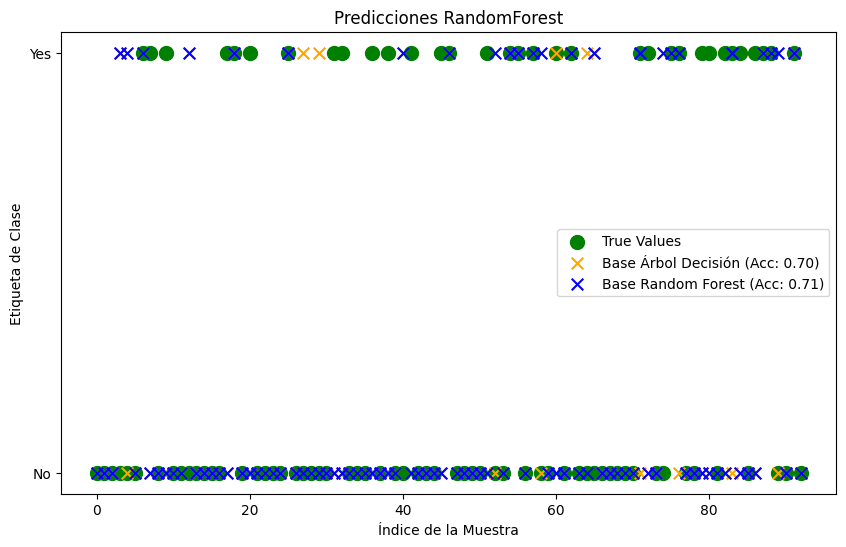

In [10]:
# Crear un gráfico de dispersión para comparar las predicciones
plt.figure(figsize=(10, 6))

plt.scatter(np.arange(len(y_test)), y_test, color='green', label='True Values', marker='o', s=100)
plt.scatter(np.arange(len(y_test)), y_pred_base, color='orange', label=f'Base Árbol Decisión (Acc: {accuracy_a:.2f})', marker='x', s=70)
plt.scatter(np.arange(len(y_test)), y_pred_rf, color='blue', label=f'Base Random Forest (Acc: {accuracy_rf:.2f})', marker='x', s=70)

plt.title('Predicciones RandomForest')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Etiqueta de Clase')
plt.legend()
plt.show()

In [11]:
# se procede a observar el posible sobreajuste comparando predicciones en train y test.
# predicciones significativamente mayores en train que en test puede indicar sobreajuste.
# Predicciones en conjunto de entrenamiento y prueba
y_train_pred = RF_model.predict(X_train)
y_test_pred = RF_model.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print('Nótese la diferencia en accuracy para ambos conjuntos de datos y el posible sobreajuste.')

Se tiene un accuracy para train de: 0.8346883468834688
Se tiene un accuracy para test de: 0.7096774193548387
Nótese la diferencia en accuracy para ambos conjuntos de datos y el posible sobreajuste.


In [12]:
RF_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10,
                       min_samples_split=10, n_estimators=60, random_state=123)>

In [13]:
# Se puede seleccionar un grill extenso y meditado sobre los distintos parámetros con los que jugar.
params = {
    'n_estimators' : [50,100,150,200,250],
    'max_depth': [2, 3, 5, 10, 20],
    'bootstrap': [True, False],
    'min_samples_leaf' : [3,10,30],
    'min_samples_split': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
#recordar que arbol2 es el árbol cuyas VI son todas las variables.
# cv = crossvalidation
grid_search_RF = GridSearchCV(estimator=RF_model, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_RF.fit(X_train, y_train)


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=20,
                                              min_samples_leaf=10,
                                              min_samples_split=10,
                                              n_estimators=60,
                                              random_state=123),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [3, 10, 30],
                         'min_samples_split': [5, 10, 20, 50, 100],
                         'n_estimators': [50, 100, 150, 200, 250]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [14]:
print('En el caso anterior, se observa que el parámetro max_depth tiene un valor de 20, indicador que de mayores valores\n pueden suponer mejora, por lo que modificar el grill puede ser indicado en ese parámetro. \nIgualmente puede ocurrir con min_samples_split, el cual, parece indicar la búsqueda \nde valores menores y más continuados, por ejemplo: [8,9,10,11,12]')

En el caso anterior, se observa que el parámetro max_depth tiene un valor de 20, indicador que de mayores valores
 pueden suponer mejora, por lo que modificar el grill puede ser indicado en ese parámetro. 
Igualmente puede ocurrir con min_samples_split, el cual, parece indicar la búsqueda 
de valores menores y más continuados, por ejemplo: [8,9,10,11,12]


In [15]:
# Obtener el mejor modelo
best_model_RF = grid_search_RF.best_estimator_
print(grid_search_RF.best_estimator_)
y_pred_rf = best_model_RF.predict(X_test)
accuracy_rf_gs = accuracy_score(y_test, y_pred_rf)
# Evaluar el rendimiento del modelo
print(f'Precisión del árbol estándar: {accuracy_rf_gs}')

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_leaf=10, min_samples_split=100,
                       n_estimators=250, random_state=123)
Precisión del árbol estándar: 0.6989247311827957


In [16]:
# se procede a observar el posible sobreajuste comparando predicciones en train y test.
# predicciones significativamente mayores en train que en test puede indicar sobreajuste.
# Predicciones en conjunto de entrenamiento y prueba
y_train_pred = best_model_RF.predict(X_train)
y_test_pred = best_model_RF.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print('Comprobar que la diferencia no sea muy grande por temas de sobreajuste')

Se tiene un accuracy para train de: 0.7886178861788617
Se tiene un accuracy para test de: 0.6989247311827957
Comprobar que la diferencia no sea muy grande por temas de sobreajuste


In [17]:
# Obtener resultados del grid search
results = pd.DataFrame(grid_search_RF.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
0,0.090747,0.020386,0.011505,0.000881,True,gini,2,3,5,50,...,0.583507,0.053125,1214,0.523688,0.469358,0.661711,0.611688,0.566611,0.074794,1218
1,0.159501,0.007773,0.013988,0.000709,True,gini,2,3,5,100,...,0.575342,0.042917,1263,0.523688,0.488889,0.641558,0.581818,0.558988,0.058093,1242
2,0.225519,0.006122,0.015755,0.001087,True,gini,2,3,5,150,...,0.577677,0.039296,1241,0.545626,0.469358,0.598927,0.623188,0.559275,0.059010,1241
3,0.298482,0.001663,0.018510,0.000510,True,gini,2,3,5,200,...,0.583633,0.041885,1210,0.553457,0.469358,0.620650,0.623188,0.566663,0.062754,1215
4,0.401729,0.046671,0.021012,0.000978,True,gini,2,3,5,250,...,0.583507,0.050774,1214,0.531143,0.469358,0.661711,0.602878,0.566272,0.072586,1220


In [18]:
print(results.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_bootstrap', 'param_criterion', 'param_max_depth',
       'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_precision_macro', 'split1_test_precision_macro',
       'split2_test_precision_macro', 'split3_test_precision_macro',
       'mean_test_precision_macro', 'std_test_precision_macro',
       'rank_test_precision_macro', 'split0_test_recall_macro',
       'split1_test_recall_macro', 'split2_test_recall_macro',
       'split3_test_recall_macro', 'mean_test_recall_macro',
       'std_test_recall_macro', 'rank_test_recall_macro',
       'split0_test_f1_macro', 'split1_test_f1_macro', 'split2_test_f1_macro',
       'split3_test_f1_macro', 'mean_test_f1_macro', 'std_

In [37]:
# Ordenar el DataFrame por la métrica de interés (por ejemplo, accuracy)
sorted_results = results.sort_values(by='mean_test_accuracy', ascending=False).head(5)
print(sorted_results)

      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1474       0.294504      0.001638         0.019996        0.000721   
1399       0.302489      0.013469         0.020749        0.002165   
924        0.861999      0.236770         0.050757        0.026904   
1074       0.278242      0.025656         0.019249        0.000432   
999        0.344510      0.068014         0.024991        0.005794   

      param_bootstrap param_criterion  param_max_depth  \
1474            False         entropy               20   
1399            False         entropy               10   
924             False            gini                5   
1074            False            gini               20   
999             False            gini               10   

      param_min_samples_leaf  param_min_samples_split  param_n_estimators  \
1474                      10                      100                 250   
1399                      10                      100                 250   

In [51]:
results_g = results.sort_values(by='mean_test_accuracy', ascending=False)

eje_x = "param_min_samples_split"
eje_y = 'mean_test_accuracy'
barras = "param_n_estimators"

plt.figure(figsize=(8, 5))

variables_interesantes = ["param_min_samples_split", ]

results_g1 = results_g.groupby([eje_x, barras])[eje_y].mean()
print(results_g1)

for i in list(results_g1[barras]):
    plt.plot(results_g1[results_g1[barras]==i], results_g1[eje_y], label=i)
plt.plot( results_g1)
plt.legend()
plt.show()

param_min_samples_split  param_n_estimators
5                        50                    0.697309
                         100                   0.697482
                         150                   0.696853
                         200                   0.697890
                         250                   0.698024
10                       50                    0.699023
                         100                   0.699380
                         150                   0.699064
                         200                   0.700149
                         250                   0.699606
20                       50                    0.699972
                         100                   0.701819
                         150                   0.700644
                         200                   0.701770
                         250                   0.701410
50                       50                    0.703769
                         100                   0.704650
    

KeyError: 'param_n_estimators'

<Figure size 800x500 with 0 Axes>

In [20]:
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

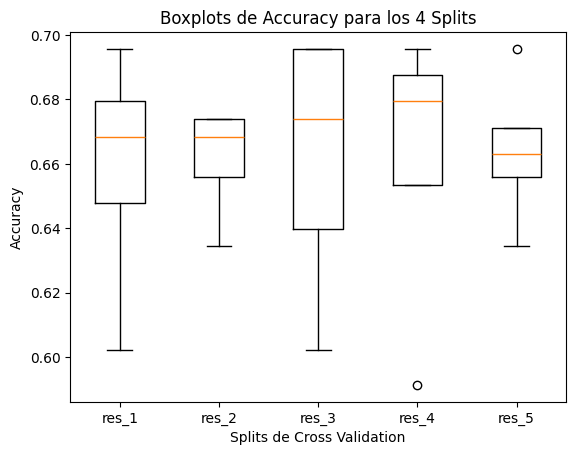

In [21]:
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values,res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()
# Nótese en la solución que boxplots con gran amplitud no son deseables, ya que se caracterizan por poca robustez de la solución

In [22]:
# seleccionemos el segundo modelo dada su mayor robustez con respecto al propuesto por GridSearch
# nótese que "**" es para desempaquetar una lista de valores.
random_f_2 = RandomForestClassifier(**sorted_results['params'].iloc[1],random_state=123)
random_f_2.fit(X_train, y_train)
res_rf_2 = random_f_2.predict(X_test)

In [23]:
accuracy_score(y_test,res_rf_2)

0.6989247311827957

In [24]:
# Si se quiere conocer quién tiene mayor robustez en sensibilidad por cuestiones de criterio exógeno:
sorted_results[['std_test_recall_macro']]

,std_test_recall_macro
1052,0.041808
421,0.015585
977,0.045500
1054,0.051148
981,0.030065


In [25]:
print('Resultados para Modelo')
print(classification_report(y_test, res_rf_2))

Resultados para Modelo
              precision    recall  f1-score   support

          No       0.70      0.93      0.80        60
         Yes       0.69      0.27      0.39        33

    accuracy                           0.70        93
   macro avg       0.70      0.60      0.60        93
weighted avg       0.70      0.70      0.65        93



A CONTINUACIÓN, SE REALIZARÁ EL EJEMPLO PARA EL CASO DE PROBLEMAS DE REGRESIÓN.

In [26]:
file_path = 'C:/Users/user/OneDrive - Universidad Complutense de Madrid (UCM)/Escritorio/A_Doctorado/23/00_DOCENCIA/Máster Tit_Propio/Árboles/compress.csv'  # Reemplaza con la ruta correcta de tu archivo
file_path_3 = 'E:/OneDrive - Universidad Complutense de Madrid (UCM)/Escritorio/A_Doctorado/23/00_DOCENCIA/Máster Tit_Propio/Árboles/compress.csv'  # Reemplaza con la ruta correcta de tu archivo

compress = pd.read_csv(file_path_3)
compress.head()

FileNotFoundError: [Errno 2] No such file or directory: 'E:/OneDrive - Universidad Complutense de Madrid (UCM)/Escritorio/A_Doctorado/23/00_DOCENCIA/Máster Tit_Propio/Árboles/compress.csv'

In [ ]:
# Separar las variables predictoras y la variable de respuesta.
X_c = compress.drop('cstrength', axis=1)
y_c = compress['cstrength']

RF_R = RandomForestRegressor(n_estimators = 60,bootstrap = True, max_depth = 20, min_samples_split=10, criterion='absolute_error',min_samples_leaf = 10,random_state=123)
# Crear un conjunto de entrenamiento y uno de prueba
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=123)
# Construir el modelo de árbol de decisiones
RF_R.fit(X_train_c, y_train_c)

RandomForestRegressor(criterion='absolute_error', max_depth=20,
                      min_samples_leaf=10, min_samples_split=10,
                      n_estimators=60, random_state=123)

In [ ]:
#se valora el posible sobreajuste
pred_rf_c_train = RF_R.predict(X_train_c)
pred_rf_c_test = RF_R.predict(X_test_c)
print(f'MAE del modelo en train:{mean_absolute_error(y_train_c,pred_rf_c_train)}')
print(f'MAE del modelo en test:{mean_absolute_error(y_test_c,pred_rf_c)}')

MAE del modelo en train:4.046392597087379
MAE del modelo en test:4.916126618122975


In [ ]:
# En caso de necesitar probar diferentes parametrizaciones. En este caso, iremos directamente a la validación cruzada.
params_c = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_split': [5, 10, 20, 50, 100],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}
# Definir las métricas de evaluación que deseas utilizar



In [ ]:
print(RF_R.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 60, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


In [ ]:
scoring_metrics_c = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error)
}
# los parámetros necesitan presentar formato lista.
params = {
    'bootstrap': [True], 
    'criterion': ['absolute_error'], 
    'max_depth': [20], 
    'max_features': [1.0], 
    'min_samples_leaf': [10], 
    'min_samples_split': [10],
    'n_estimators': [60],
    'random_state': [123]
}
grid_search_rf_c = GridSearchCV(estimator=RF_R, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics_c, refit='MAE')
grid_search_rf_c.fit(X_train_c, y_train_c)

GridSearchCV(cv=4,
             estimator=RandomForestRegressor(criterion='absolute_error',
                                             max_depth=20, min_samples_leaf=10,
                                             min_samples_split=10,
                                             n_estimators=60,
                                             random_state=123),
             param_grid={'bootstrap': [True], 'criterion': ['absolute_error'],
                         'max_depth': [20], 'max_features': [1.0],
                         'min_samples_leaf': [10], 'min_samples_split': [10],
                         'n_estimators': [60], 'random_state': [123]},
             refit='MAE',
             scoring={'MAE': make_scorer(mean_absolute_error),
                      'MSE': make_scorer(mean_squared_error)})

In [ ]:
pd.DataFrame(grid_search_c.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,...,mean_test_MAE,std_test_MAE,rank_test_MAE,split0_test_MSE,split1_test_MSE,split2_test_MSE,split3_test_MSE,mean_test_MSE,std_test_MSE,rank_test_MSE
0,0.500562,0.008079,0.008319,0.008319,True,absolute_error,20,1.0,10,10,...,5.332337,0.270328,1,46.600223,46.403586,48.97246,55.02191,49.249545,3.482648,1


split0_test_MAE    5.202713
split1_test_MAE    5.168623
split2_test_MAE    5.158319
split3_test_MAE    5.799694
Name: 0, dtype: float64


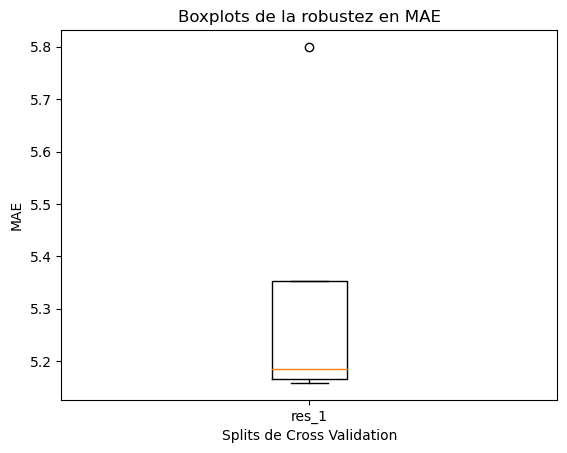

In [ ]:
res_1 = pd.DataFrame(grid_search_c.cv_results_)[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[0]
print(res_1)
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values], labels = ['res_1'])
plt.title('Boxplots de la robustez en MAE')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('MAE')
plt.show()

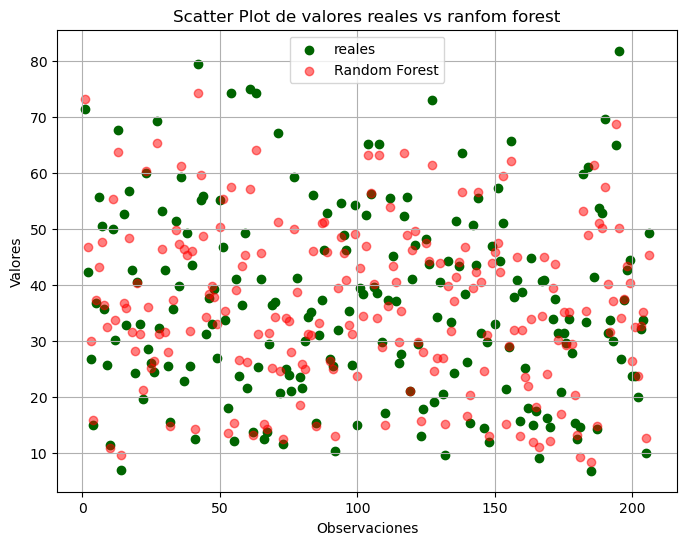

In [ ]:
indices = np.arange(1, len(y_test_c) + 1)

plt.figure(figsize=(8, 6))
plt.scatter(indices, y_test_c, color='darkgreen', label='reales')  # Puedes ajustar el color según tus preferencias

plt.scatter(indices, pred_rf_c_test, color='red', alpha=0.5, label='Random Forest')  # Puedes ajustar el color y la transparencia según tus preferencias

plt.title('Scatter Plot de valores reales vs ranfom forest')
plt.xlabel('Observaciones')
plt.ylabel('Valores')
plt.legend()  # Agregar leyenda
plt.grid(True)
plt.show()

In [ ]:
# Calcular diferentes medidas de bondad de ajuste
mae = mean_absolute_error(y_test_c, pred_rf_c_test)
mse = mean_squared_error(y_test_c, pred_rf_c_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_c, pred_rf_c_test)

# Imprimir las métricas
print(f'MAE (Error Absoluto Medio): {mae:.2f}')
print(f'MSE (Error Cuadrático Medio): {mse:.2f}')
print(f'RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}')
print(f'R2: {r2}')

MAE (Error Absoluto Medio): 4.92
MSE (Error Cuadrático Medio): 43.83
RMSE (Raíz del Error Cuadrático Medio): 6.62
R2: 0.8402963970008323
